In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
import statsmodels.stats.multitest as multi

## Settings

In [2]:
sns.set_style("white")
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
#flatui = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
#flatui = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
sns.set_palette(colors)

In [3]:
x_size, y_size = 12,8
plt.rcParams.update({'font.size': 12})

# Read the data

In [4]:
df = pd.read_csv("data\\google_data_preprocessed.csv", encoding="utf8")

In [5]:
df = df[["date", "hour", "route_id", "workday", "weather", "pace"]]
#df = df[["date", "hour", "route_id", "workday", "pace"]]

# Rescale per hour

In [6]:
df = df.groupby(["date", "hour", "route_id", "workday", "weather"], as_index=False).mean()
#df = df.groupby(["date", "hour", "route_id", "workday"], as_index=False).mean()

# Counters per route

In [7]:
f = open("data\\counters_per_route.txt", encoding="utf8")
route_counters = {}

for l in f:
    ss = l.strip().split(";")
    route_id = ss[0] 
    route_id = int(route_id)
    cs = ss[1:]    
    if cs != ['']:
        route_counters[route_id] = cs
    
 
    
route_counters    

{0: ['1016-140', '1034-216-1', '1038-276', '1025-116'],
 1: ['1016-140', '1947-211', '1946-230-1'],
 2: ['1935-230', '1035-136'],
 3: ['1014-150'],
 4: ['1001-156', '1021-156'],
 5: ['0174-1', '0855-1', '1010-1']}

# Prepare the main df

In [8]:
df_orig = df.copy()

for counters in route_counters.values():
    for counter_id in counters:
        df[counter_id] = np.nan

# Read counter data

In [9]:
df_counters = pd.read_csv("data\counters.csv", encoding="utf8")

In [10]:
#df_counters = df_counters[["date", "time", "counter_id_direction", "count"]]
#df_counters.columns = ["date", "hour", "counter_id", "count"]
df_counters = df_counters[["date", "time", "counter_id", "count"]]

In [11]:
# Test: odstrani avtocesto
#df_counters = df_counters[df_counters["counter_id"] != 'HC-H3, LJ (S obvoznica) : LJ (Celovška - Dunajska)']

In [12]:
for route_id, counters in route_counters.items():
    
    for counter_id in counters:
        if not counter_id:
            continue       
        
        print(counter_id, route_id)
        
        df3 = df_counters[df_counters["counter_id"]==counter_id].copy()
        df3 = df3.drop(columns=["counter_id"])
        df3.columns = ["date", "hour", counter_id]
        df3["route_id"] = route_id
        
        df2 = pd.merge(df_orig, df3, how="left", on=["route_id", "date", "hour"])
        df.update(df2)
         

1016-140 0
1034-216-1 0
1038-276 0
1025-116 0
1016-140 1
1947-211 1
1946-230-1 1
1935-230 2
1035-136 2
1014-150 3
1001-156 4
1021-156 4
0174-1 5
0855-1 5
1010-1 5


In [13]:
df.to_csv("data\\counter_hours.csv", index=False)

# Pairplots and correlations

In [14]:
#route_counters2 = {3:route_counters[3]}

In [15]:
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r_P, _ = pearsonr(x, y)
    r_S, _ = spearmanr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho_P = '$r_P$'
    rho_S = '$r_S$'#'\u03C1$'
    ax.annotate(f'{rho_P} = {r_P:.2f}, {rho_S} = {r_S:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

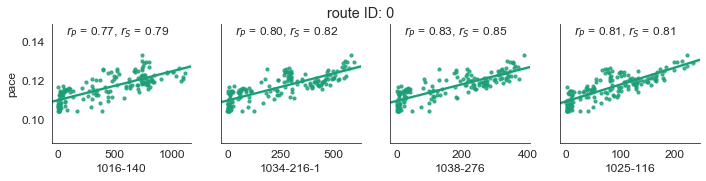

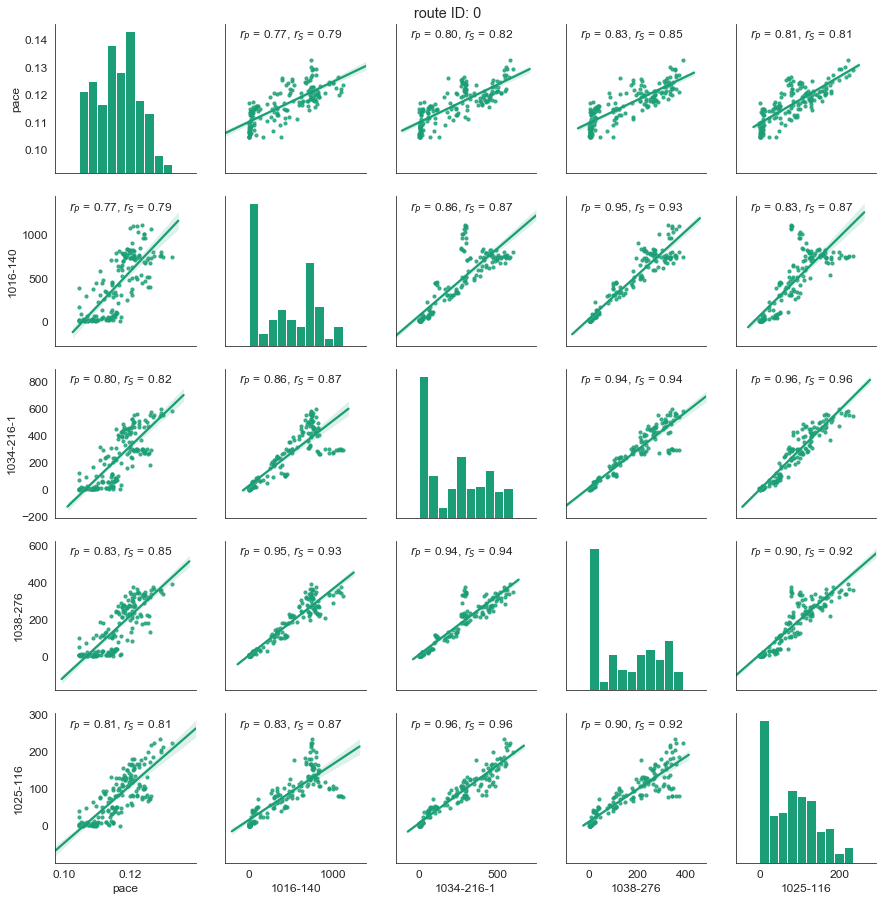

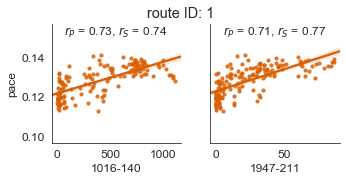

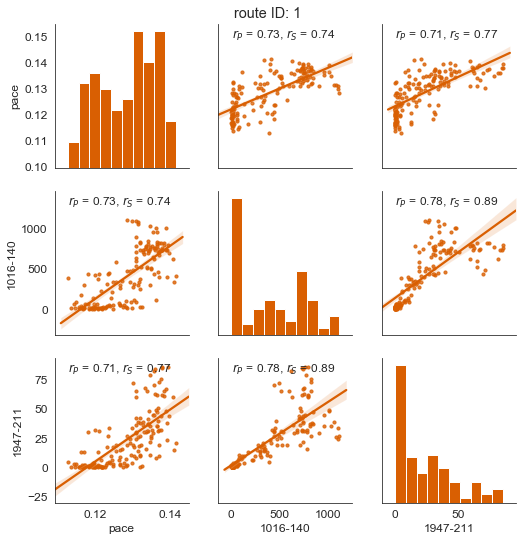

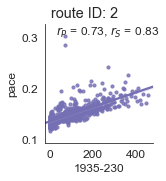

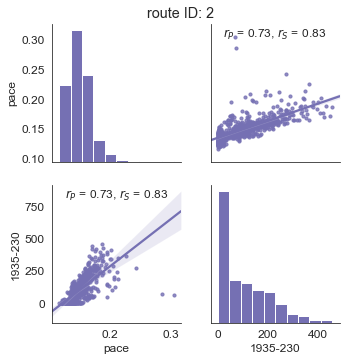

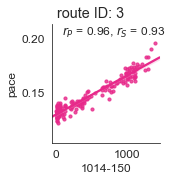

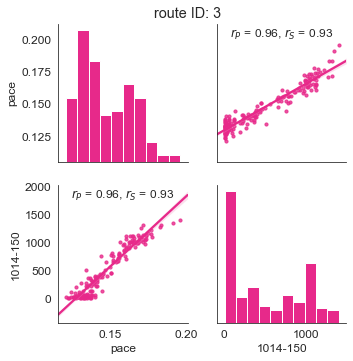

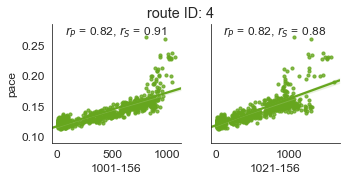

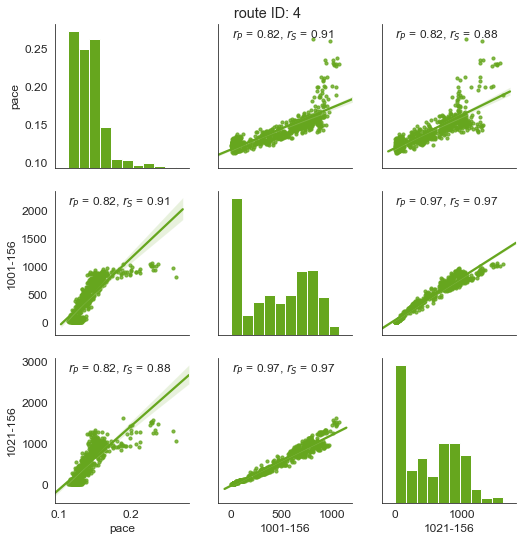

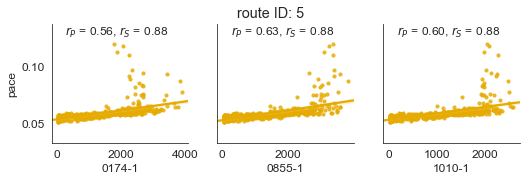

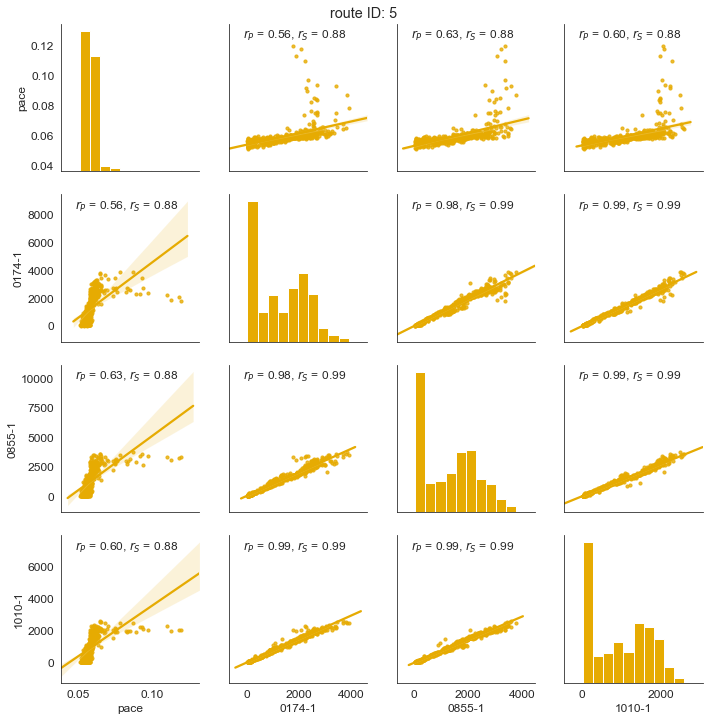

In [16]:
df_corr = pd.DataFrame(columns=["route_id", "counter_id", "Pearson_r", "Pearson_p", "Pearson_q", "Spearman_r", "Spearman_p", "Spearman_q"])

for i, (route_id, counters) in enumerate(route_counters.items()):    
    
    sns.set_palette([colors[i]])
    
    
    df2 = df[df["route_id"]==route_id][["pace"] + counters].copy()
    df2 = df2.dropna(axis='columns', how="all")
    df2 = df2.dropna(axis="rows")
            
    g = sns.pairplot(df2, y_vars = ["pace"], x_vars = df2.columns[1:], kind="reg", plot_kws=dict(scatter_kws=dict(s=10)))    
    g.map(corrfunc)
    #g.map_lower(corrfunc)
    g.fig.suptitle("route ID: " + str(int(route_id)), y=1) # y= some height>1
    plt.savefig("figs\\pairplots\\route_"+str(int(route_id))+"_pairplot_small.pdf", bbox_inches="tight")
    plt.savefig("figs\\pairplots\\route_"+str(int(route_id))+"_pairplot_small.png", bbox_inches="tight")
    plt.savefig("figs\\pairplots\\route_"+str(int(route_id))+"_pairplot_small.svg", bbox_inches="tight")
    
    
    plt.show()
    
    
    g = sns.pairplot(df2, kind="reg", plot_kws=dict(scatter_kws=dict(s=10)))  
    #g.map(corrfunc)
    g.map_lower(corrfunc)
    g.map_upper(corrfunc)
    g.fig.suptitle("route ID: " + str(int(route_id)), y=1) # y= some height>1
    plt.savefig("figs\\pairplots\\route_"+str(int(route_id))+"_pairplot.pdf", bbox_inches="tight")
    plt.savefig("figs\\pairplots\\route_"+str(int(route_id))+"_pairplot.png", bbox_inches="tight")
    plt.savefig("figs\\pairplots\\route_"+str(int(route_id))+"_pairplot.svg", bbox_inches="tight")
    
    
    plt.show()
    
    Y = df2["pace"].values
    for counter in df2.columns[1:]:
        X = df2[counter].values
        p_r,p_p = pearsonr(X,Y)
        s_r,s_p = spearmanr(X,Y)
        
        
        df_corr = df_corr.append(pd.DataFrame({"route_id": [route_id],
                                               "counter_id": [counter],
                                               "Pearson_r": [p_r],
                                               "Pearson_p": [p_p],
                                               "Spearman_r": [s_r],
                                               "Spearman_p": [s_p]}), ignore_index=True, sort = False)
            
            
        

df_corr["Pearson_q"] = multi.multipletests(df_corr["Pearson_p"], method = 'fdr_bh')[1]
df_corr["Spearman_q"] = multi.multipletests(df_corr["Spearman_p"], method = 'fdr_bh')[1]
    
    
    
    

In [17]:
#s_r,s_p = spearmanr(X,Y)
#p_r,p_p = pearsonr(X,Y)
#df_corr.to_csv("regression_results\\correlations.csv", index=False)


In [18]:
df_corr2 = df_corr
df_corr2.columns = ["route ID", "counter ID", "r_P", "p(r_P)", "q(r_P)", "r_S", "p(r_S)", "q(r_S)"]
df_corr2[df_corr2.columns[2:]] = df_corr2[df_corr2.columns[2:]].applymap(lambda x: round(x,2))
df_corr2.to_csv("regression_results\\correlations.csv", index=False, sep="\t")

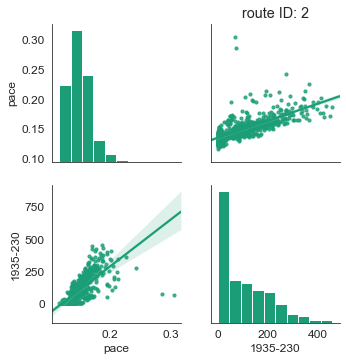

In [19]:
route_counters2 = {}
route_counters2[2] = route_counters[2]
for i, (route_id, counters) in enumerate(route_counters2.items()):    
    
    sns.set_palette([colors[i]])
    
    
    df2 = df[df["route_id"]==route_id][["pace"] + counters].copy()
    df2 = df2.dropna(axis='columns', how="all")
    
            
    sns.pairplot(df2.dropna(axis="rows"), kind="reg", plot_kws=dict(scatter_kws=dict(s=10)))
    plt.title("route ID: " + str(int(route_id)))
    plt.show()

In [20]:
df[(~df['1935-230'].isna()) & (df['route_id']==2)]

,date,hour,route_id,workday,weather,pace,1016-140,1034-216-1,1038-276,1025-116,1947-211,1946-230-1,1935-230,1035-136,1014-150,1001-156,1021-156,0174-1,0855-1,1010-1
2,2020-10-04,23,2,0,good,0.134565,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-10-05,0,2,1,good,0.131214,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2020-10-05,1,2,1,good,0.137508,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2020-10-05,2,2,1,good,0.136467,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2020-10-05,3,2,1,good,0.130037,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2020-10-05,4,2,1,good,0.131894,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,2020-10-05,5,2,1,good,0.139591,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,2020-10-05,6,2,1,good,0.163543,NaN,NaN,NaN,NaN,NaN,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2020-10-05,7,2,1,good,0.194648,NaN,NaN,NaN,NaN,NaN,NaN,153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2020-10-05,8,2,1,good,0.206239,NaN,NaN,NaN,NaN,NaN,NaN,188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df

,date,hour,route_id,workday,weather,pace,1016-140,1034-216-1,1038-276,1025-116,1947-211,1946-230-1,1935-230,1035-136,1014-150,1001-156,1021-156,0174-1,0855-1,1010-1
0,2020-10-04,23,0,0,good,0.114544,NaN,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-04,23,1,0,good,0.132463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-04,23,2,0,good,0.134565,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-04,23,3,0,good,0.137983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-04,23,4,0,good,0.125304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,78.0,NaN,NaN,NaN
5,2020-10-04,23,5,0,good,0.052332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,321.0,165.0
6,2020-10-05,0,0,1,good,0.111981,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-10-05,0,1,1,good,0.129918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-10-05,0,2,1,good,0.131214,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-10-05,0,3,1,good,0.142058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data export

In [22]:
df.to_csv("data\\pace_counters.csv", encoding="utf8", index=False)

# Remove route info

In [23]:
#df2 = df.drop(columns=["route_id", "pace"]).copy()
#df2 = df2.groupby(['date','hour','weather'], as_index=False).max()
#df2 = df2.dropna(axis='columns', how="all")

In [23]:
#df2.to_csv("data\\counters_filtered.csv", encoding="utf8", index=False)